### Load Packages

In [36]:
import os
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import pydicom as dicom
import imutils

def read_file():
    '''
       You need to put the pic files into the fixed file path, now 
       only two file formats could be supported(.his file and .dcm file)
       Input: path storing files
       Output: image file array(n,row,colum) 
    '''
    path = os.getcwd()
    list_file = sorted(os.listdir(os.path.join(path,'BB_Ball')))
    
    print(list_file)
    flag = list_file[0].split('.')   
    
    if flag[1].lower() == 'dcm':        
        img_data = []
        for item in list_file:
            img = dicom.read_file(os.path.join(path,'Cone',item),force=True)
            img_data.append(img)
        img_data = np.stack([s.pixel_array for s in img_data])

        for i in range(len(list_file)):
            min_ = np.min(img_data[i,])
            max_ = np.max(img_data[i,])
            img_data[i,] = (img_data[i,]-min_)/(max_-min_)*255
        img_data = img_data.astype('uint8') ## To make sure the pic is 8 bit to avoid the error in circles
        
        return img_data
            
    elif flag[1].lower() == 'his':
        img_data = np.ones([len(list_file),1024,1024])
        for i in range(len(list_file)):
            pic = open(os.path.join(path,'BB_Ball',list_file[i]),'rb')

            line = pic.readlines()
            raw_data = b''
            for item in line:raw_data+=item
            data = np.fromstring(raw_data, dtype='int16')
            img_data[i] = data[50:].reshape((1024,1024))
    
        for i in range(len(list_file)):
            min_ = np.min(img_data[i,])
            max_ = np.max(img_data[i,])
            img_data[i,] = (img_data[i,]-min_)/(max_-min_)*255
        img_data = img_data.astype('uint8') ## To make sure the pic is 8 bit to avoid the error in circles
        
        return img_data


In [37]:
img_data = read_file()

['1.his', '2.his', '3.his', '4.his', '5.his', '6.his', '7.his', '8.his']


c:\users\exthuaxia\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Image pair: (1,2), (3,4), (5,6), (7,8)

### Plot the Image

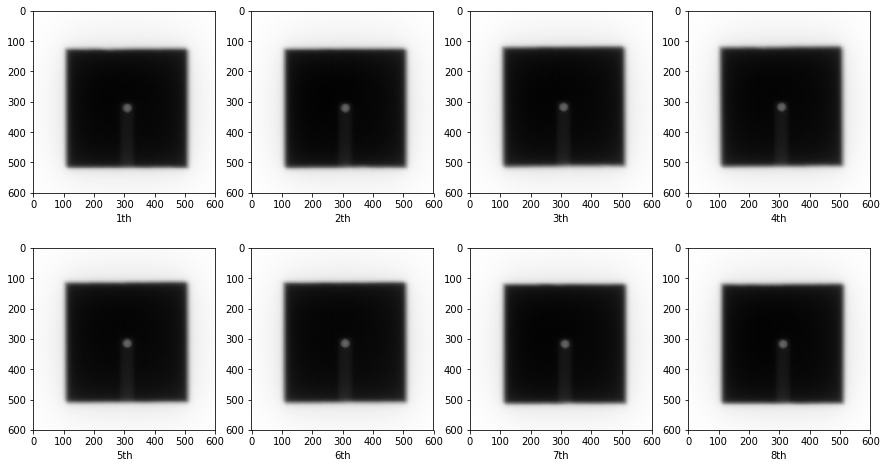

In [38]:
set_x = 200
set_y = 800

plt.figure(figsize=(15,8))
for i in range(img_data.shape[0]):
    plt.subplot(241+i)
    plt.imshow(img_data[i,set_x:set_y,set_x:set_y],'gray')
    plt.xlabel('{}th'.format(i+1))
plt.show()

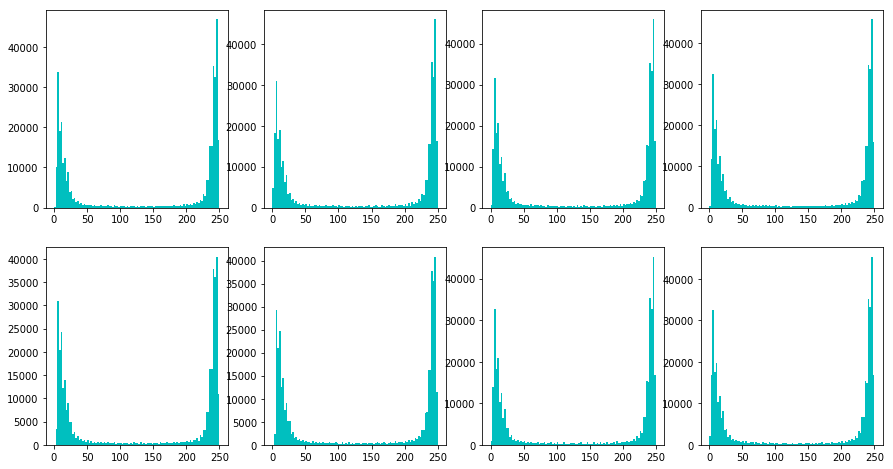

In [39]:
plt.figure(figsize=(15,8))
for i in range(img_data.shape[0]):
    plt.subplot(241+i)
    plt.hist(img_data[i,set_x:set_y,set_x:set_y].flatten(),bins=100,color='c')
plt.show()

In [74]:
cir_out = []
for i in img_data:
    cir_out.append(cv2.HoughCircles(i,cv2.HOUGH_GRADIENT,1,1000,
                                   param1=60,param2=25,minRadius=10,maxRadius=45))

In [75]:
for i in range(img_data.shape[0]):
    cv2.circle(img_data[i,],(cir_out[i][0][0][0],cir_out[i][0][0][1]),cir_out[i][0][0][2]+np.float32(0.5),(0,255,0),1)
    cv2.circle(img_data[i,],(cir_out[i][0][0][0],cir_out[i][0][0][1]),1,(0,255,0),-1)

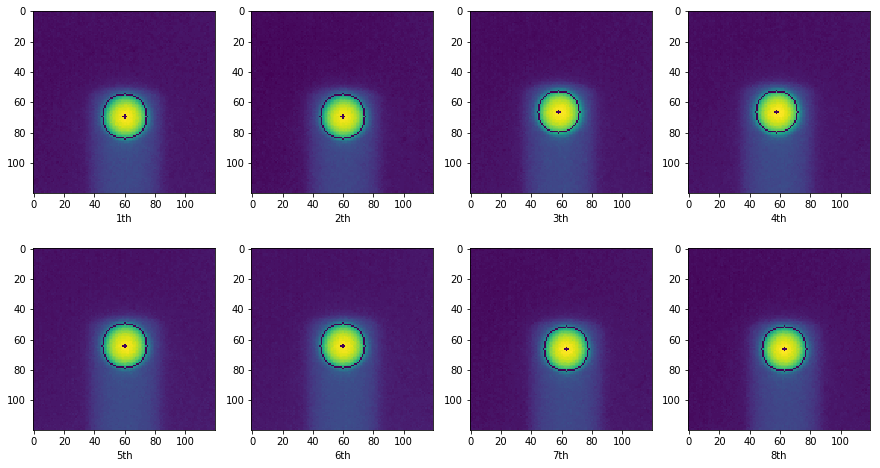

In [76]:
plt.figure(figsize=(15,8))
for i in range(img_data.shape[0]):
    plt.subplot(241+i)
    plt.imshow(img_data[i,set_x:set_y,set_x:set_y])
    plt.xlabel('{}th'.format(i+1))
plt.show()

### Listed the circle center and radius information

In [77]:
cir_out

[array([[[510.5, 519.5,  14.5]]], dtype=float32),
 array([[[510.5, 519.5,  14.9]]], dtype=float32),
 array([[[508.5, 516.5,  14.3]]], dtype=float32),
 array([[[508.5, 516.5,  14.3]]], dtype=float32),
 array([[[510.5, 514.5,  15.2]]], dtype=float32),
 array([[[510.5, 514.5,  14.9]]], dtype=float32),
 array([[[513.5, 516.5,  14.7]]], dtype=float32),
 array([[[513.5, 516.5,  14.7]]], dtype=float32)]

**It seems no location difference in image pairs or it's so tiny that couldn't be detected.**

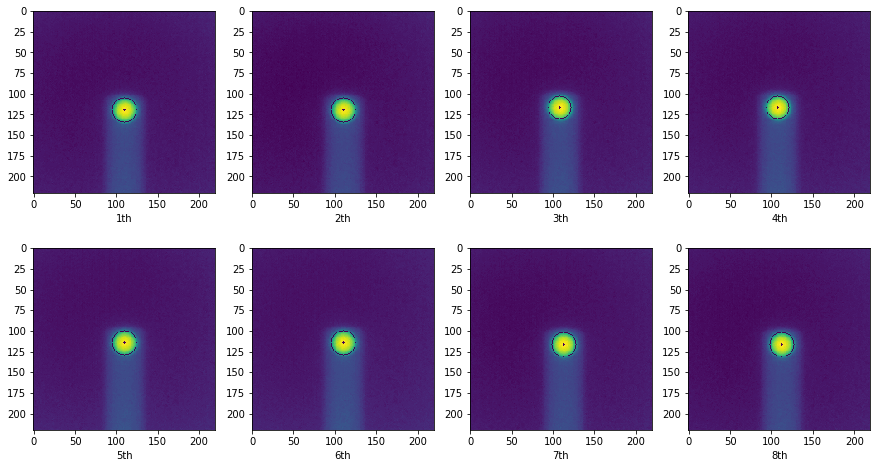

In [78]:
plt.figure(figsize=(15,8))
for i in range(img_data.shape[0]):
    plt.subplot(241+i)
    plt.imshow(img_data[i,set_x-50:set_y+50,set_x-50:set_y+50])
    plt.xlabel('{}th'.format(i+1))
plt.show()

### Find squares in images

In [59]:
img_copy = img_data.copy()
img_copy.dtype

dtype('uint8')

In [60]:
# load the image, convert it to grayscale, blur it slightly 
# and threshold it
for i in range(img_copy.shape[0]):
    
    blurred = cv2.GaussianBlur(img_copy[i], (5, 5), 0)
    thresh = cv2.threshold(blurred, 120, 255, cv2.THRESH_BINARY_INV)[1]
    
    # find contours in the thresholded image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    # loop over the contours
    for c in cnts:
        # compute the center of the contour
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        # draw the contour and center of the shape on the image
        cv2.drawContours(img_copy[i], [c], -1, (0, 255, 0), 2)
        cv2.circle(img_copy[i], (cX, cY), 7, (255, 255, 255), -1)
        cv2.putText(img_copy[i], "center", (cX - 20, cY - 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
        print('{0}th field center is ({1},{2})'.format(i+1,cX,cY))

1th field center is (509,520)
2th field center is (510,519)
3th field center is (508,514)
4th field center is (507,514)
5th field center is (508,510)
6th field center is (509,510)
7th field center is (512,515)
8th field center is (511,515)


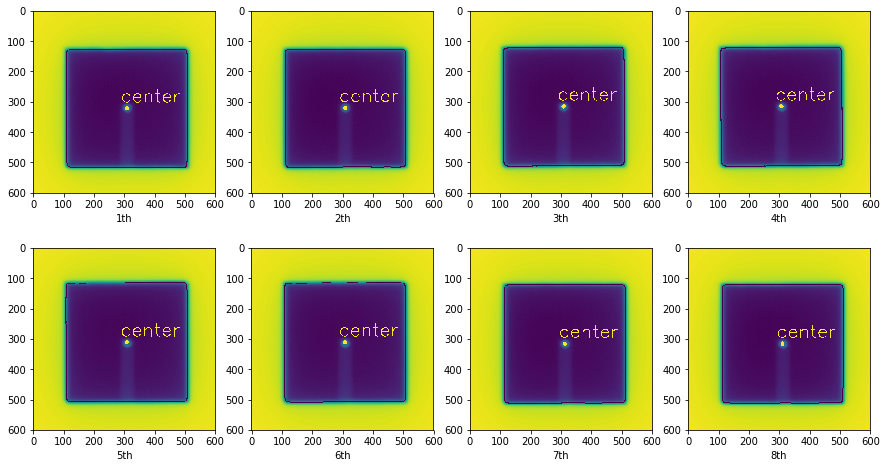

In [61]:
plt.figure(figsize=(15,8))
for i in range(img_copy.shape[0]):
    plt.subplot(241+i)
    plt.imshow(img_copy[i,set_x:set_y,set_x:set_y])
    plt.xlabel('{}th'.format(i+1))
plt.show()

#### Field centers in pixels(X_Width,Y_Height):

<font color=#0000FF >1th field center is (509,520) and 2th field center is (510,519)</font>  

<font color=#0000FF >3th field center is (508,514) and 4th field center is (507,514)</font>  

<font color=#0000FF >5th field center is (508,510) and 6th field center is (509,510)</font>  

<font color=#0000FF >7th field center is (512,515) and 8th field center is (511,515)</font>  

#### Ball centers in pixels(X_Width,Y_Height):

<font color=#A52A2A >1th Ball center is (510.5,519.5) and 2th Ball center is (510.5, 519.5)</font>  

<font color=#A52A2A >3th Ball center is (508.5, 516.5) and 4th Ball center is (508.5, 516.5)</font>  

<font color=#A52A2A >5th Ball center is (510.5, 514.5) and 6th Ball center is (510.5, 514.5)</font>  

<font color=#A52A2A >7th Ball center is (513.5, 516.5) and 8th Ball center is (513.5, 516.5)</font> 